In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteMY4W86/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteMY4W86/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

   return input_image, input_mask

In [ ]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

In [ ]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [ ]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [ ]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

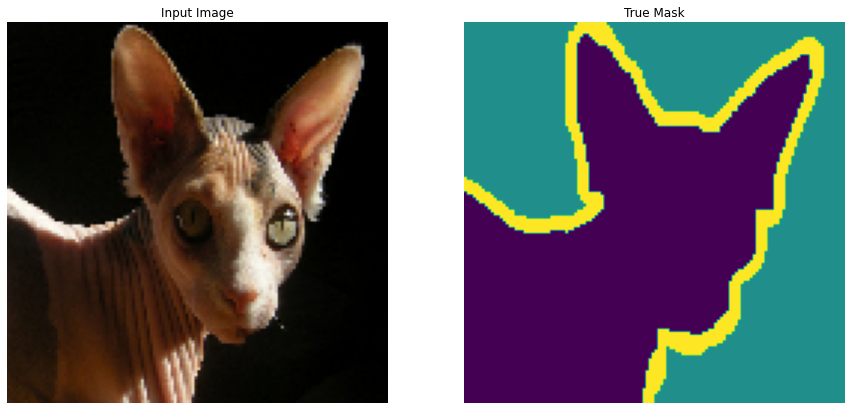

In [ ]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [ ]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, kernel_size = 3, padding = "same", activation = "relu", kernel_initializer = "he_normal", use_bias = False)(x)
   x = layers.BatchNormalization()(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, kernel_size = 3, padding = "same", activation = "relu", kernel_initializer = "he_normal", use_bias = False)(x)
   x = layers.BatchNormalization()(x)

   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.BatchNormalization()(p)
   p = layers.Dropout(0.3)(p)

   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same", use_bias = False)(x)
   x = layers.BatchNormalization()(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [ ]:
# inputs
inputs = layers.Input(shape=(128,128,3)) # h,w = 128

# encoder: contracting path - downsample
# 1 - downsample
f1, p1 = downsample_block(inputs, 64) # h,w = 64
# 2 - downsample
f2, p2 = downsample_block(p1, 128) # h,w = 32
# 3 - downsample
f3, p3 = downsample_block(p2, 256) # h,w = 16 
# 4 - downsample
f4, p4 = downsample_block(p3, 512) # h,w = 8

# 5 - bottleneck
bottleneck = double_conv_block(p4, 1024)
# decoder: expanding path - upsample
# 6 - upsample
u6 = upsample_block(bottleneck, f4, 512)
# 7 - upsample
u7 = upsample_block(u6, f3, 256)
# 8 - upsample
u8 = upsample_block(u7, f2, 128)
# 9 - upsample
u9 = upsample_block(u8, f1, 64)

# outputs
outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

# unet model with Keras Functional API
unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [ ]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/20
57/57 [==============================] - 70s 1s/step - loss: 0.8391 - accuracy: 0.6468 - val_loss: 7669.8706 - val_accuracy: 0.2939
Epoch 2/20
57/57 [==============================] - 68s 1s/step - loss: 0.5925 - accuracy: 0.7661 - val_loss: 320.5603 - val_accuracy: 0.3300
Epoch 3/20
57/57 [==============================] - 69s 1s/step - loss: 0.5092 - accuracy: 0.8010 - val_loss: 6.0122 - val_accuracy: 0.5416
Epoch 4/20
57/57 [==============================] - 71s 1s/step - loss: 0.4460 - accuracy: 0.8263 - val_loss: 4.2282 - val_accuracy: 0.5560
Epoch 5/20
57/57 [==============================] - 71s 1s/step - loss: 0.3982 - accuracy: 0.8455 - val_loss: 1.4721 - val_accuracy: 0.6777
Epoch 6/20
57/57 [==============================] - 71s 1s/step - loss: 0.3732 - accuracy: 0.8554 - val_loss: 1.1505 - val_accuracy: 0.7474
Epoch 7/20
57/57 [==============================] - 71s 1s/step - loss: 0.3519 - accuracy: 0.8636 - val_loss: 0.5739 - val_accuracy: 0.8340
Epoch 8/20
57/5

In [ ]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]

def show_predictions(dataset=None, num=1):
 if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
 else:
   display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)

number of batches: 11


2/2 [==============================] - 1s 189ms/step


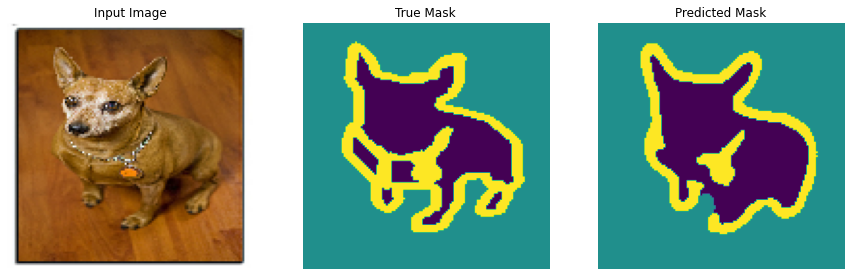

In [ ]:
show_predictions(dataset = test_batches)